In [1]:
import sqlite3 as sq
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec as gs
from matplotlib.ticker import MultipleLocator
# %matplotlib inline

In [2]:
data_base_name = 'Employee_Data.db'
table_one = "2009_v.1"
table_two = "2009_v.2"
table_three = "personal_data"

# creating a sex chart
with sq.connect(data_base_name) as con:
    # making a selection from the database to create a table 'Cтруктура работников цеха по половому признаку'
    gender_structure = pd.read_sql(f'''SELECT Sex, count(Sex) as Amount FROM
                            (
                            SELECT "Personnel number", Sex
                            from "{table_two}"
                            GROUP by "Personnel number"
                            )
                        GROUP by Sex''', con)

  Sex  Amount
0   Ж      45
1   М     155


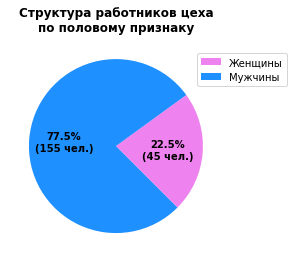

In [3]:
    # data on the number of men and women for the pie chart:
    values = gender_structure['Amount'].tolist()

    # data for pie chart legend:
    labels = ['Женщины' if s == 'Ж' else 'Мужчины' for s in gender_structure['Sex'].tolist()]

    # pie chart settings:
    my = plt.pie(values,
                 colors=('violet', 'dodgerblue'),
                 startangle=-45,
                 autopct=lambda x: f'{round(x, 1)}%\n({int(round(x * sum(values) / 100, 0))} чел.)',
                 textprops=dict(color="black", size=10, weight='bold')
                 )
    plt.title('Cтруктура работников цеха\nпо половому признаку',
              size=12,
              weight='bold',
              )

    plt.legend(labels, bbox_to_anchor=(0.85, 0.95))

    print(gender_structure)

    plt.show()

In [4]:
# creating an age chart
with sq.connect('Employee_Data.db') as con:
    # create a new DataFrame from DataBase:
    df = pd.read_sql(f'''select "Date of birth", Sex 
                        from "{table_two}"
                        group by "Personnel number"
                        ''', con)

    # change the data type in the column "Date of birth" from str to datetime:
    df['Date of birth'] = pd.to_datetime(df['Date of birth'])

    # create data for new df column "Age" (employee age in 2009 year):
    current_date = pd.to_datetime('2009-12-31')
    age = df['Date of birth'].apply(lambda d_of_b: int((current_date - d_of_b).days / 365))

    # add new column "Age" to DataFrame df:
    df['Age'] = age

    # delete column "Date of birth" from DataFrame df:
    df.drop('Date of birth', axis=1, inplace=True)

    # create a dictionary with data for the age chart:
    age_dict = {}

    for df_sex, df_age in df.values:
        age_dict.setdefault(df_sex, {'моложе 24': 0,
                                     'от 24 до 29': 0,
                                     'от 30 до 39': 0,
                                     'от 40 до 50': 0,
                                     'старше 50': 0})
        if df_age < 24:
            age_dict[df_sex]['моложе 24'] += 1
        if 23 < df_age < 30:
            age_dict[df_sex]['от 24 до 29'] += 1
        if 29 < df_age < 40:
            age_dict[df_sex]['от 30 до 39'] += 1
        if 39 < df_age < 51:
            age_dict[df_sex]['от 40 до 50'] += 1
        if 50 < df_age:
            age_dict[df_sex]['старше 50'] += 1

    # create a DataFrame with data for the age chart:
    age_df = pd.DataFrame(age_dict)

    # rename columns:
    axe_label = 'Возраст (лет)'
    m = 'Мужчины (чел.)'
    f = 'Женщины (чел.)'
    age_df.rename(columns={'М': f'{m}', 'Ж': f'{f}'}, inplace=True)

    # let's call the column with indexes:
    age_df.index.names = [f'{axe_label}']

               Мужчины (чел.)  Женщины (чел.)
Возраст (лет)                                
моложе 24                  16               7
от 24 до 29                18               8
от 30 до 39                42               8
от 40 до 50                42               9
старше 50                  37              13


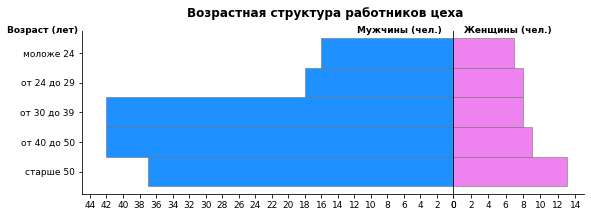

In [5]:
    # create the age chart:

    # create a 'figure' object to draw diagrams on it:
    fig = plt.figure(figsize=(9, 3))

    # create a grid on the 'figure' object to form cells for diagrams:
    gridsp = gs(ncols=50,  # number of columns
                nrows=1,  # number of rows
                figure=fig)

    # set the gap width between cells:
    plt.subplots_adjust(wspace=0)

    # set the size of the first diagram (i.e. in which cells it will be located) on the 'figure' object:
    ax1 = plt.subplot(gridsp[0, :37])

    # set the boundary values along the X axis:
    plt.xlim([0, age_df[f'{m}'].to_numpy().max() + 3])

    # set the scale step along the X axis:
    ax1.xaxis.set_major_locator(MultipleLocator(base=2))

    # turn the X-axis in the opposite direction:
    ax1.invert_xaxis()

    # turn the Y-axis in the opposite direction:
    ax1.invert_yaxis()

    # set the parameters of the first diagram (see the documentation for "pyplot.barh"):
    plt.barh(age_df.index.to_numpy(), age_df[f'{m}'],
             color='dodgerblue',
             height=1,
             edgecolor='dimgrey',
             linewidth=0.5,
             )
    # hide unnecessary chart axes (boundaries of the field in which the chart is built):
    ax1.spines['top'].set_visible(False)  # upper bound
    ax1.spines['right'].set_visible(False)  # right border

    # set the parameters (in this case, the font size) of the labels on the axes:
    plt.tick_params(axis='both', which='major', labelsize=9)

    # set the dimensions of the second diagram (i.e. in which cells it will be located) on the 'figure' object:
    ax2 = plt.subplot(gridsp[0, 37:], yticks=[])  # 'yticks' hides labels along the axis Y

    # set the boundary values along the X axis:
    plt.xlim([0, age_df[f'{f}'].to_numpy().max() + 2])

    # set the scale step along the X axis:
    ax2.xaxis.set_major_locator(MultipleLocator(base=2))

    # turn the Y-axis in the opposite direction:
    ax2.invert_yaxis()

    # set the parameters of the second diagram (see the documentation for "pyplot.barh"):
    plt.barh(age_df.index.to_numpy(), age_df[f'{f}'],
             color='violet',
             height=1,
             edgecolor='dimgrey',
             linewidth=0.5,
             )

    # hide unnecessary chart axes (boundaries of the field in which the chart is built):
    ax2.spines['top'].set_visible(False)  # upper bound
    ax2.spines['right'].set_visible(False)  # right border

    # set the parameters (in this case, the font size) of the labels on the axes:
    plt.tick_params(axis='x', which='major', labelsize=9)

    # add text to the object 'figure':
    fig.suptitle('Возрастная структура работников цеха',  # name of the finished chart
                 size=12,
                 weight='bold',
                 y=0.99
                 )
    plt.figtext(0.55, 0.87, f'{m}', weight='bold', size=9)  # labeling of the left diagram
    plt.figtext(0.715, 0.87, f'{f}', weight='bold', size=9)  # labeling of the right diagram
    plt.figtext(0.01, 0.87, f'{axe_label}', weight='bold', size=9)  # name of Y-axis

    print(age_df)
    plt.show()


In [6]:
with sq.connect("Employee_Data.db") as con:

    # create labels for axes:
    pv = 'Объем производства, ед.'
    inc = 'Зарплатный фонд, руб.'
    m = 'Расчетный месяц'

    # create a new DataFrame from DataBase:
    vol_sal = pd.read_sql(f'''SELECT Month as "{m}", avg("Production volume") as "{pv}",
                              (sum(Income) / 10 * 10) as "{inc}"
                              from "{table_two}"
                              GROUP by "{m}"
                              order by "{m}"''', con)

    # convert the numeric designation of the date into a letter in Russian:
    ind = pd.DatetimeIndex(vol_sal[f'{m}']).month_name(locale='Russian')

    # convert the volume value from float into integer:
    vol_sal[f'{pv}'] = vol_sal[f'{pv}'].astype(int)

    # create a final DataFrame:
    vol_sal = vol_sal.loc[:, [f'{pv}', f'{inc}']].set_index(ind)

                 Объем производства, ед.  Зарплатный фонд, руб.
Расчетный месяц                                                
Январь                               580                3977190
Февраль                              790                3977190
Март                                 820                3977190
Апрель                              1200                4679020
Май                                 1250                4779270
Июнь                                 950                4177700
Июль                                1400                5080080
Август                              1180                4638910
Сентябрь                            1080                4438400
Октябрь                              780                3977190
Ноябрь                              1020                4318060
Декабрь                              810                3977190


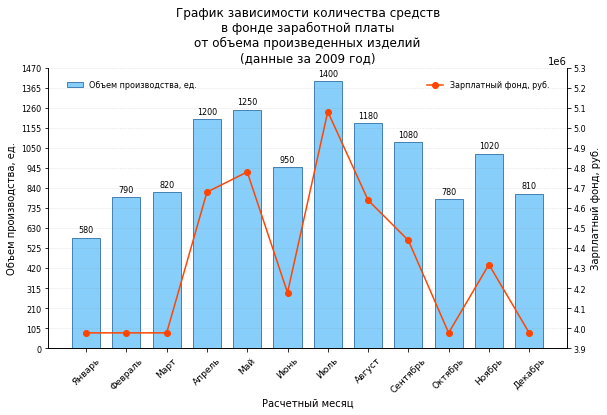

In [7]:
    # prepare data for bar-plot chart:
    x_values1 = vol_sal.index  # ticks' designation for x-axis
    y_values1 = vol_sal[f'{pv}']  # ticks' designation for y1-axis
    y_values2 = vol_sal[f'{inc}']  # ticks' designation for y2-axis

    # create a bar-plot chart:
    fig = plt.figure(figsize=(9, 6))

    # assign a chart location on the figure object:
    plt.subplots_adjust(left=0.1, right=0.9, top=0.85, bottom=0.2)

    # create the first axis:
    ax1 = fig.add_subplot(111)

    # take a few steps to create 'Grouped bar chart with labels':
    rects = ax1.bar(x_values1, y_values1, color="lightskyblue", width=0.7, edgecolor='steelblue', label=f'{pv}')
    ax1.bar_label(rects, padding=3, size=8)  # matplotlib tutorial: Grouped bar chart with labels

    ax1.set_xlabel(f"{m}", color="black", size=10, fontweight='book')
    ax1.set_ylabel(f"{pv}", color="black", size=10, fontweight='book')
    ax1.set_yticks(np.linspace(ax1.get_ybound()[0], ax1.get_ybound()[1], 15))
    ax1.tick_params(axis='x', colors="black", labelsize=9, rotation=45)
    ax1.tick_params(axis='y', colors="black", labelsize=8)
    ax1.spines['top'].set_visible(False)
    plt.legend(bbox_to_anchor=(0.3, 0.98), fontsize=8, frameon=False)

    # create the second axis:
    ax2 = ax1.twinx()
    ax2.plot(x_values1, y_values2, color="orangered", marker='o', label=f'{inc}')
    ax2.set_ylabel(f"{inc}", color="black", size=10, fontweight='book')
    ax2.set_yticks(np.linspace(39 * 1e5, 53 * 1e5, 15))
    ax2.tick_params(axis='y', colors="black", labelsize=8)
    ax2.spines['top'].set_visible(False)
    plt.legend(bbox_to_anchor=(0.98, 0.98), fontsize=8, frameon=False)
    plt.grid(linestyle='--', color='gray', linewidth=0.5, alpha=0.25)

    plt.title('График зависимости количества средств\n'
              'в фонде заработной платы\n'
              'от объема произведенных изделий\n'
              '(данные за 2009 год)',
              fontweight='book')

    print(vol_sal)
    plt.show()
